Using device: cuda
Pruning: keeping 134 / 200 points


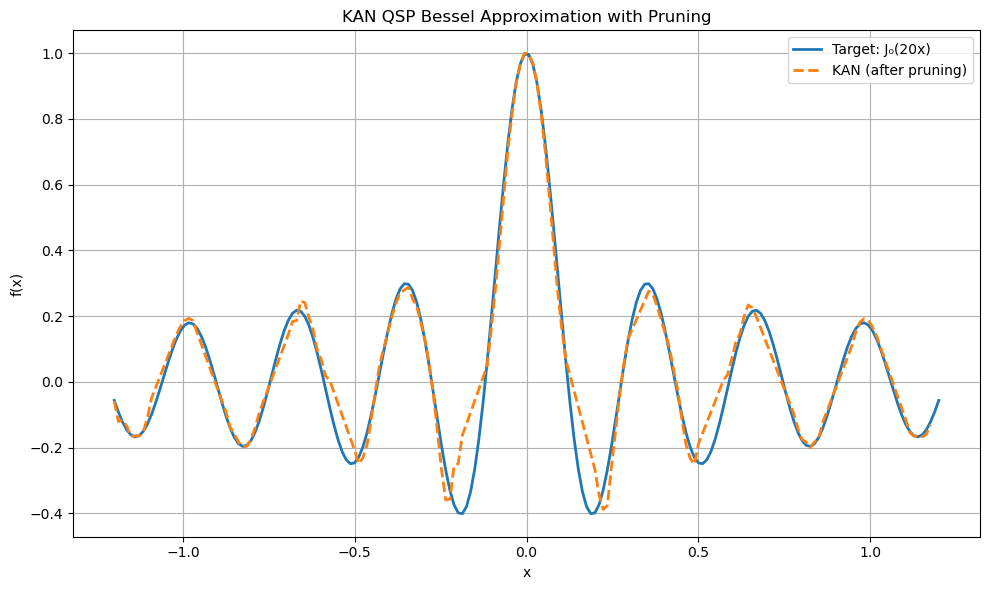

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import j0
from kan.KAN import KAN
from kan.qsp_activation import expectation_value

# -------------------------------
# Device setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Edge-warped sampling function
# -------------------------------
def warp_edges(L):
    t = np.linspace(0, np.pi, L)
    x_dense = np.cos(t)
    return np.sort(x_dense).reshape(-1, 1)

# -------------------------------
# Weighted cost function
# -------------------------------
def weighted_cost_fn(params, x, y_norm, depth, lambda_reg=1e-3):
    qsp_params = params[:2 * depth + 1]
    alphas = params[2 * depth + 1:]

    preds, weights = [], []
    for i in range(len(x)):
        theta = x[i][0]
        val = expectation_value(qsp_params, theta, depth=depth)
        preds.append(alphas[i] * val)
        weights.append(1 + 10 * (abs(theta) ** 2))

    preds = np.array(preds)
    weights = np.array(weights)
    mse = np.mean(weights * (y_norm.flatten() - preds) ** 2)
    alpha_penalty = lambda_reg * np.mean(np.square(alphas))
    return mse + alpha_penalty

# -------------------------------
# Train and optionally prune
# -------------------------------
def train_and_prune(x, y, width, qsp_depth=35, steps=1000, pruning_threshold=0.05):
    model = KAN(width, qsp_depth=qsp_depth, device=device)

    x_tensor = torch.tensor(x, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y, dtype=torch.float32, device=device)

    y_max = np.max(np.abs(y))
    y_norm = y / y_max

    init_qsp_params = np.linspace(0, np.pi, model.num_qsp_params)
    init_alphas = np.random.uniform(0.5, 1.5, x.shape[0])
    init_params = np.concatenate([init_qsp_params, init_alphas])

    result = model.fit_qsp_with_alphas(
        x_tensor, y_tensor,
        maxiter=steps,
        cost_fn=lambda p: weighted_cost_fn(p, x, y_norm, depth=qsp_depth),
        init_params=init_params
    )
    qsp_params = result.x[:model.num_qsp_params]
    alphas = result.x[model.num_qsp_params:]

    # -------------------------------
    # Pruning: keep samples with significant alpha × QSP(theta)
    # -------------------------------
    importance = np.abs([
        alphas[i] * expectation_value(qsp_params, x[i][0], depth=qsp_depth)
        for i in range(len(x))
    ])
    keep_indices = np.where(importance > pruning_threshold)[0]
    print(f"Pruning: keeping {len(keep_indices)} / {len(x)} points")

    # Retrain if pruning reduced the set
    if len(keep_indices) < len(x):
        x_pruned = x[keep_indices]
        y_pruned = y[keep_indices]
        model = KAN(width, qsp_depth=qsp_depth, device=device)
        x_tensor = torch.tensor(x_pruned, dtype=torch.float32, device=device)
        y_tensor = torch.tensor(y_pruned, dtype=torch.float32, device=device)

        result = model.fit_qsp_with_alphas(
            x_tensor, y_tensor,
            maxiter=steps,
            cost_fn=lambda p: weighted_cost_fn(p, x_pruned, y_pruned / y_max, qsp_depth),
            init_params=np.concatenate([qsp_params, alphas[keep_indices]])
        )
        qsp_params = result.x[:model.num_qsp_params]
        alphas = result.x[model.num_qsp_params:]

        preds = model(x_tensor, qsp_params, alphas).detach().cpu().numpy()
        preds = preds * y_max
        return model, preds, x_pruned, y_pruned

    else:
        preds = model(x_tensor, qsp_params, alphas).detach().cpu().numpy()
        preds = preds * y_max
        return model, preds, x, y

# -------------------------------
# Main execution
# -------------------------------
x_full = np.linspace(-1.2, 1.2, 200).reshape(-1, 1)
y_full = j0(20 * x_full)

model, preds_full, x_used, y_used = train_and_prune(
    x_full, y_full, width=[10, 10, 1], steps=1000, pruning_threshold=0.05
)

# -------------------------------
# Plotting
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(x_full, y_full, label="Target: J₀(20x)", linewidth=2)
plt.plot(x_used, preds_full, '--', label="KAN (after pruning)", linewidth=2)
plt.title("KAN QSP Bessel Approximation with Pruning")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Using device: cuda
Pruning: keeping 91 / 200 points


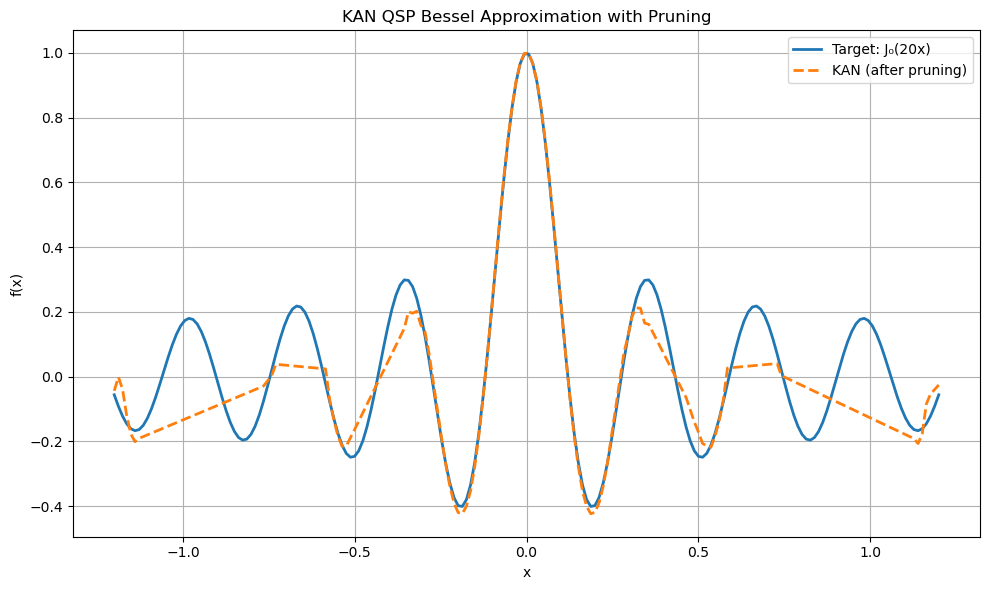

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import j0
from kan.KAN import KAN
from kan.qsp_activation import expectation_value

# -------------------------------
# Device setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Edge-warped sampling function
# -------------------------------
def warp_edges(L):
    t = np.linspace(0, np.pi, L)
    x_dense = np.cos(t)
    return np.sort(x_dense).reshape(-1, 1)

# -------------------------------
# Weighted cost function
# -------------------------------
def weighted_cost_fn(params, x, y_norm, depth, lambda_reg=1e-3):
    qsp_params = params[:2 * depth + 1]
    alphas = params[2 * depth + 1:]

    preds, weights = [], []
    for i in range(len(x)):
        theta = x[i][0]
        val = expectation_value(qsp_params, theta, depth=depth)
        preds.append(alphas[i] * val)
        weights.append(1 + 10 * (abs(theta) ** 2))

    preds = np.array(preds)
    weights = np.array(weights)
    mse = np.mean(weights * (y_norm.flatten() - preds) ** 2)
    alpha_penalty = lambda_reg * np.mean(np.square(alphas))
    return mse + alpha_penalty

# -------------------------------
# Train and optionally prune
# -------------------------------
def train_and_prune(x, y, width, qsp_depth=15, steps=1000, pruning_threshold=0.05):
    model = KAN(width, qsp_depth=qsp_depth, device=device)

    x_tensor = torch.tensor(x, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y, dtype=torch.float32, device=device)

    y_max = np.max(np.abs(y))
    y_norm = y / y_max

    init_qsp_params = np.linspace(0, np.pi, model.num_qsp_params)
    init_alphas = np.random.uniform(0.5, 1.5, x.shape[0])
    init_params = np.concatenate([init_qsp_params, init_alphas])

    result = model.fit_qsp_with_alphas(
        x_tensor, y_tensor,
        maxiter=steps,
        cost_fn=lambda p: weighted_cost_fn(p, x, y_norm, depth=qsp_depth),
        init_params=init_params
    )
    qsp_params = result.x[:model.num_qsp_params]
    alphas = result.x[model.num_qsp_params:]

    # -------------------------------
    # Pruning: keep samples with significant alpha × QSP(theta)
    # -------------------------------
    importance = np.abs([
        alphas[i] * expectation_value(qsp_params, x[i][0], depth=qsp_depth)
        for i in range(len(x))
    ])
    keep_indices = np.where(importance > pruning_threshold)[0]
    print(f"Pruning: keeping {len(keep_indices)} / {len(x)} points")

    # Retrain if pruning reduced the set
    if len(keep_indices) < len(x):
        x_pruned = x[keep_indices]
        y_pruned = y[keep_indices]
        model = KAN(width, qsp_depth=qsp_depth, device=device)
        x_tensor = torch.tensor(x_pruned, dtype=torch.float32, device=device)
        y_tensor = torch.tensor(y_pruned, dtype=torch.float32, device=device)

        result = model.fit_qsp_with_alphas(
            x_tensor, y_tensor,
            maxiter=steps,
            cost_fn=lambda p: weighted_cost_fn(p, x_pruned, y_pruned / y_max, qsp_depth),
            init_params=np.concatenate([qsp_params, alphas[keep_indices]])
        )
        qsp_params = result.x[:model.num_qsp_params]
        alphas = result.x[model.num_qsp_params:]

        preds = model(x_tensor, qsp_params, alphas).detach().cpu().numpy()
        preds = preds * y_max
        return model, preds, x_pruned, y_pruned

    else:
        preds = model(x_tensor, qsp_params, alphas).detach().cpu().numpy()
        preds = preds * y_max
        return model, preds, x, y

# -------------------------------
# Main execution
# -------------------------------
x_full = np.linspace(-1.2, 1.2, 200).reshape(-1, 1)
y_full = j0(20 * x_full)

model, preds_full, x_used, y_used = train_and_prune(
    x_full, y_full, width=[1, 1], steps=1000, pruning_threshold=0.05
)

# -------------------------------
# Plotting
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(x_full, y_full, label="Target: J₀(20x)", linewidth=2)
plt.plot(x_used, preds_full, '--', label="KAN (after pruning)", linewidth=2)
plt.title("KAN QSP Bessel Approximation with Pruning")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Using device: cuda
Pruning: keeping 134 / 200 points


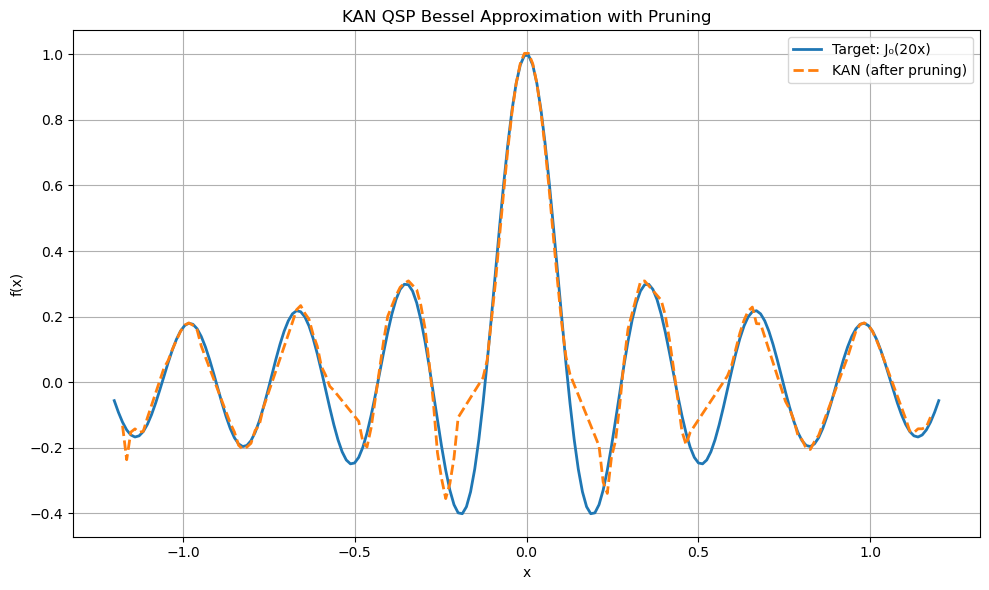

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import j0
from kan.KAN import KAN
from kan.qsp_activation import expectation_value

# -------------------------------
# Device setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Edge-warped sampling function
# -------------------------------
def warp_edges(L):
    t = np.linspace(0, np.pi, L)
    x_dense = np.cos(t)
    return np.sort(x_dense).reshape(-1, 1)

# -------------------------------
# Weighted cost function
# -------------------------------
def weighted_cost_fn(params, x, y_norm, depth, lambda_reg=1e-3):
    qsp_params = params[:2 * depth + 1]
    alphas = params[2 * depth + 1:]

    preds, weights = [], []
    for i in range(len(x)):
        theta = x[i][0]
        val = expectation_value(qsp_params, theta, depth=depth)
        preds.append(alphas[i] * val)
        weights.append(1 + 10 * (abs(theta) ** 2))

    preds = np.array(preds)
    weights = np.array(weights)
    mse = np.mean(weights * (y_norm.flatten() - preds) ** 2)
    alpha_penalty = lambda_reg * np.mean(np.square(alphas))
    return mse + alpha_penalty

# -------------------------------
# Train and optionally prune
# -------------------------------
def train_and_prune(x, y, width, qsp_depth=35, steps=1000, pruning_threshold=0.05):
    model = KAN(width, qsp_depth=qsp_depth, device=device)

    x_tensor = torch.tensor(x, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y, dtype=torch.float32, device=device)

    y_max = np.max(np.abs(y))
    y_norm = y / y_max

    init_qsp_params = np.linspace(0, np.pi, model.num_qsp_params)
    init_alphas = np.random.uniform(0.5, 1.5, x.shape[0])
    init_params = np.concatenate([init_qsp_params, init_alphas])

    result = model.fit_qsp_with_alphas(
        x_tensor, y_tensor,
        maxiter=steps,
        cost_fn=lambda p: weighted_cost_fn(p, x, y_norm, depth=qsp_depth),
        init_params=init_params
    )
    qsp_params = result.x[:model.num_qsp_params]
    alphas = result.x[model.num_qsp_params:]

    # -------------------------------
    # Pruning: keep samples with significant alpha × QSP(theta)
    # -------------------------------
    importance = np.abs([
        alphas[i] * expectation_value(qsp_params, x[i][0], depth=qsp_depth)
        for i in range(len(x))
    ])
    keep_indices = np.where(importance > pruning_threshold)[0]
    print(f"Pruning: keeping {len(keep_indices)} / {len(x)} points")

    # Retrain if pruning reduced the set
    if len(keep_indices) < len(x):
        x_pruned = x[keep_indices]
        y_pruned = y[keep_indices]
        model = KAN(width, qsp_depth=qsp_depth, device=device)
        x_tensor = torch.tensor(x_pruned, dtype=torch.float32, device=device)
        y_tensor = torch.tensor(y_pruned, dtype=torch.float32, device=device)

        result = model.fit_qsp_with_alphas(
            x_tensor, y_tensor,
            maxiter=steps,
            cost_fn=lambda p: weighted_cost_fn(p, x_pruned, y_pruned / y_max, qsp_depth),
            init_params=np.concatenate([qsp_params, alphas[keep_indices]])
        )
        qsp_params = result.x[:model.num_qsp_params]
        alphas = result.x[model.num_qsp_params:]

        preds = model(x_tensor, qsp_params, alphas).detach().cpu().numpy()
        preds = preds * y_max
        return model, preds, x_pruned, y_pruned

    else:
        preds = model(x_tensor, qsp_params, alphas).detach().cpu().numpy()
        preds = preds * y_max
        return model, preds, x, y

# -------------------------------
# Main execution
# -------------------------------
x_full = np.linspace(-1.2, 1.2, 200).reshape(-1, 1)
y_full = j0(20 * x_full)

model, preds_full, x_used, y_used = train_and_prune(
    x_full, y_full, width=[1, 1], steps=1000, pruning_threshold=0.05
)

# -------------------------------
# Plotting
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(x_full, y_full, label="Target: J₀(20x)", linewidth=2)
plt.plot(x_used, preds_full, '--', label="KAN (after pruning)", linewidth=2)
plt.title("KAN QSP Bessel Approximation with Pruning")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Using device: cuda
Pruning: keeping 98 / 200 points


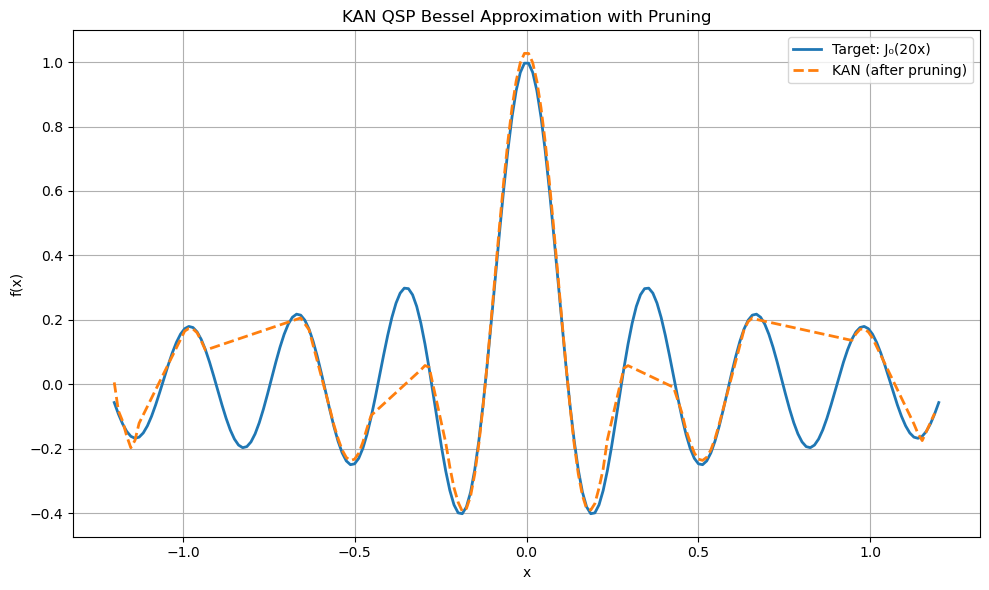

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import j0
from kan.KAN import KAN
from kan.qsp_activation import expectation_value

# -------------------------------
# Device setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Edge-warped sampling function
# -------------------------------
def warp_edges(L):
    t = np.linspace(0, np.pi, L)
    x_dense = np.cos(t)
    return np.sort(x_dense).reshape(-1, 1)

# -------------------------------
# Weighted cost function
# -------------------------------
def weighted_cost_fn(params, x, y_norm, depth, lambda_reg=1e-4):
    qsp_params = params[:2 * depth + 1]
    alphas = params[2 * depth + 1:]

    preds, weights = [], []
    for i in range(len(x)):
        theta = x[i][0]
        val = expectation_value(qsp_params, theta, depth=depth)
        preds.append(alphas[i] * val)
        weights.append(1 + 10 * (abs(theta) ** 2))

    preds = np.array(preds)
    weights = np.array(weights)
    mse = np.mean(weights * (y_norm.flatten() - preds) ** 2)
    alpha_penalty = lambda_reg * np.mean(np.square(alphas))
    return mse + alpha_penalty

# -------------------------------
# Train and optionally prune
# -------------------------------
def train_and_prune(x, y, width, qsp_depth=15, steps=1000, pruning_threshold=0.05):
    model = KAN(width, qsp_depth=qsp_depth, device=device)

    x_tensor = torch.tensor(x, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y, dtype=torch.float32, device=device)

    y_max = np.max(np.abs(y))
    y_norm = y / y_max

    init_qsp_params = np.linspace(0, np.pi, model.num_qsp_params)
    init_alphas = np.random.uniform(0.5, 1.5, x.shape[0])
    init_params = np.concatenate([init_qsp_params, init_alphas])

    result = model.fit_qsp_with_alphas(
        x_tensor, y_tensor,
        maxiter=steps,
        cost_fn=lambda p: weighted_cost_fn(p, x, y_norm, depth=qsp_depth),
        init_params=init_params
    )
    qsp_params = result.x[:model.num_qsp_params]
    alphas = result.x[model.num_qsp_params:]

    # -------------------------------
    # Pruning: keep samples with significant alpha × QSP(theta)
    # -------------------------------
    importance = np.abs([
        alphas[i] * expectation_value(qsp_params, x[i][0], depth=qsp_depth)
        for i in range(len(x))
    ])
    keep_indices = np.where(importance > pruning_threshold)[0]
    print(f"Pruning: keeping {len(keep_indices)} / {len(x)} points")

    # Retrain if pruning reduced the set
    if len(keep_indices) < len(x):
        x_pruned = x[keep_indices]
        y_pruned = y[keep_indices]
        model = KAN(width, qsp_depth=qsp_depth, device=device)
        x_tensor = torch.tensor(x_pruned, dtype=torch.float32, device=device)
        y_tensor = torch.tensor(y_pruned, dtype=torch.float32, device=device)

        result = model.fit_qsp_with_alphas(
            x_tensor, y_tensor,
            maxiter=steps,
            cost_fn=lambda p: weighted_cost_fn(p, x_pruned, y_pruned / y_max, qsp_depth),
            init_params=np.concatenate([qsp_params, alphas[keep_indices]])
        )
        qsp_params = result.x[:model.num_qsp_params]
        alphas = result.x[model.num_qsp_params:]

        preds = model(x_tensor, qsp_params, alphas).detach().cpu().numpy()
        preds = preds * y_max
        return model, preds, x_pruned, y_pruned

    else:
        preds = model(x_tensor, qsp_params, alphas).detach().cpu().numpy()
        preds = preds * y_max
        return model, preds, x, y

# -------------------------------
# Main execution
# -------------------------------
x_full = np.linspace(-1.2, 1.2, 200).reshape(-1, 1)
y_full = j0(20 * x_full)

model, preds_full, x_used, y_used = train_and_prune(
    x_full, y_full, width=[1, 10, 1], steps=1000, pruning_threshold=0.05
)

# -------------------------------
# Plotting
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(x_full, y_full, label="Target: J₀(20x)", linewidth=2)
plt.plot(x_used, preds_full, '--', label="KAN (after pruning)", linewidth=2)
plt.title("KAN QSP Bessel Approximation with Pruning")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()